## RAG

### 1. Load the data from HuggingFace

In [ ]:
from datasets import load_dataset
import pandas as pd

# Load the dataset from 
ds = load_dataset("MedRAG/pubmed")

# Get the train data， first 10k samples
train_data = ds['train']

df = pd.DataFrame(train_data[:10000])

# Save the whole train data to a csv file
df.to_csv('train.csv', index=False)

### 2. Data cleaning

In [54]:
import spacy
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
nlp = spacy.load('en_core_web_sm')

In [55]:
data_raw = pd.read_csv('train.csv')

In [56]:
data_raw.head()

,id,title,content,contents,PMID
0,pubmed23n0001_0,[Biochemical studies on camomile components/II...,(--)-alpha-Bisabolol has a primary antipeptic ...,[Biochemical studies on camomile components/II...,21
1,pubmed23n0001_1,[Demonstration of tumor inhibiting properties ...,A report is given on the recent discovery of o...,[Demonstration of tumor inhibiting properties ...,22
2,pubmed23n0001_2,Effect of etafenone on total and regional myoc...,The distribution of blood flow to the subendoc...,Effect of etafenone on total and regional myoc...,23
3,pubmed23n0001_3,Influence of a new virostatic compound on the ...,"The virostatic compound N,N-diethyl-4-[2-(2-ox...",Influence of a new virostatic compound on the ...,24
4,pubmed23n0001_4,Pharmacological properties of new neuroleptic ...,"RMI 61 140, RMI 61 144 and RMI 61 280 are newl...",Pharmacological properties of new neuroleptic ...,25


"The 'contents' field combines the title and main text, but includes many stop words and irrelevant symbols. We need to remove them to improve retrieval accuracy."

In [57]:
data_raw.iloc[0]['contents']

"[Biochemical studies on camomile components/III. In vitro studies about the antipeptic activity of (--)-alpha-bisabolol (author's transl)]. (--)-alpha-Bisabolol has a primary antipeptic action depending on dosage, which is not caused by an alteration of the pH-value. The proteolytic activity of pepsin is reduced by 50 percent through addition of bisabolol in the ratio of 1/0.5. The antipeptic action of bisabolol only occurs in case of direct contact. In case of a previous contact with the substrate, the inhibiting effect is lost."

The contents length ranges from 22 to 511, with the mean of 161.  

In [58]:
print("Min Length: " + data_raw['contents'].apply(lambda x: len(x.split(' '))).min().astype(str))
print("Max Length: " + data_raw['contents'].apply(lambda x: len(x.split(' '))).max().astype(str))
print("Mean Length:" + data_raw['contents'].apply(lambda x: len(x.split(' '))).mean().astype(str))

Min Length: 22
Max Length: 674
Mean Length:161.5436


<Axes: ylabel='Frequency'>

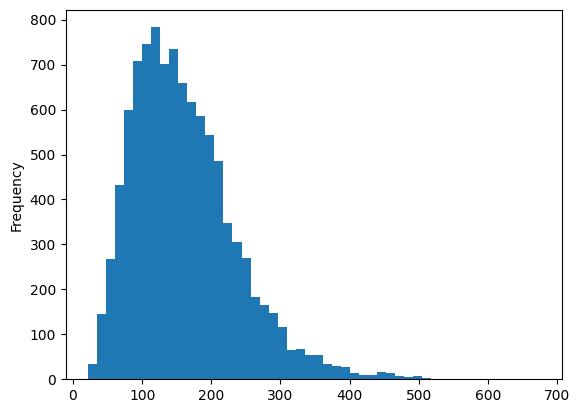

In [59]:
data_raw['contents'].apply(lambda x: len(x.split(' '))).plot(kind='hist', bins=50)

In [60]:
doc = nlp(data_raw.iloc[0]['contents'])

Only the Alphanumeric words are important, whitespace, punctuation and stop words should be excluded.

In [61]:
def token_to_df(doc=doc):
    token_info = []
    for token in doc:
        token_info.append({
            "Text": token.text,
            "Index": token.idx,
            "Whitespace": token.is_space,
            "Is Alphanumeric?": token.is_alpha,
            "Is Punctuation?": token.is_punct,
            "Is Stop Word?": token.is_stop
        })
    return pd.DataFrame(token_info)

token_to_df(doc)

,Text,Index,Whitespace,Is Alphanumeric?,Is Punctuation?,Is Stop Word?
0,[,0,False,False,True,False
1,Biochemical,1,False,True,False,False
2,studies,13,False,True,False,False
3,on,21,False,True,False,True
4,camomile,24,False,True,False,False
...,...,...,...,...,...,...
98,inhibiting,509,False,True,False,False
99,effect,520,False,True,False,False
100,is,527,False,True,False,True
101,lost,530,False,True,False,False


Lemmatization is necessary to reduce the length of the content while preserving relevant information.

In [62]:
for token in doc:
    if str(token) != str(token.lemma_):
        print(f"{str(token):>20} : {str(token.lemma_)}")

         Biochemical : biochemical
             studies : study
          components : component
                  In : in
             studies : study
                 has : have
           depending : depend
                  is : be
              caused : cause
                  pH : ph
                 The : the
                  is : be
             reduced : reduce
                 The : the
              occurs : occur
                  In : in
          inhibiting : inhibit
                  is : be
                lost : lose


In [63]:
def clean_text(text):
    complete_doc = nlp(text)
    words = [token.text for token in complete_doc 
             if token.is_alpha and not token.is_stop and not token.is_punct]
    return ' '.join(words)

def lemmalize_text(text):
    complete_doc = nlp(text)
    words = [token.lemma_ for token in complete_doc]
    return ' '.join(words)

In [64]:
text = data_raw.iloc[0]['contents']
text = clean_text(text)
text = lemmalize_text(text)
clean_doc = nlp(text)

After cleaning, the first contents length is reduced from 103 to 44.

In [65]:
token_to_df(clean_doc).shape[0]

44

Tokenization

In [66]:
def tokenized_text(text):
    complete_doc = nlp(text)
    words = [token.text.lower() for token in complete_doc]
    return words

Overall Cleaning Process(Takes 2.5 minutes to run)

In [67]:
def full_preprocessing(text):
    text = clean_text(text)
    text = lemmalize_text(text)
    text = tokenized_text(text)
    return ' '.join(text)

In [68]:
data_clean = data_raw.copy()
data_clean['cleaned'] = data_raw['contents'].transform(full_preprocessing)

After cleaning, the contents length ranges from 14 to 267, with the mean of 90. 

In [69]:
print("Min Length: " + data_clean['cleaned'].apply(lambda x: len(x.split(' '))).min().astype(str))
print("Max Length: " + data_clean['cleaned'].apply(lambda x: len(x.split(' '))).max().astype(str))
print("Mean Length:" + data_clean['cleaned'].apply(lambda x: len(x.split(' '))).mean().astype(str))

Min Length: 14
Max Length: 303
Mean Length:90.8452


<Axes: ylabel='Frequency'>

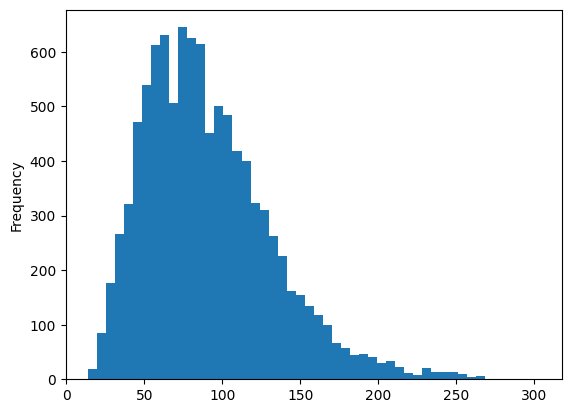

In [70]:
data_clean['cleaned'].apply(lambda x: len(x.split(' '))).plot(kind='hist', bins=50)

In [71]:
data_clean.to_csv('train_clean.csv', index=False)

### 3. Bi-encoder Implementation

In [72]:
from sentence_transformers import SentenceTransformer
import pandas as pd
import torch
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('train_clean.csv')
data_str = data['cleaned'].tolist()

# Load the SentenceTransformer model
model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')

# Encode the dataset
embeddings = model.encode(data_str)

torch.save(embeddings, 'embeddings.pt')

In [73]:
embeddings = torch.load('embeddings.pt', weights_only=False)

query = "What is the role of the protein p53 in cancer?"

# Preprocess the query
query_new = full_preprocessing(query)

# Encode the query
query_embedding = model.encode([query_new])

# Compute similarities
similarities = model.similarity(query_embedding, embeddings)

# Get the top `n` most similar papers
similarities_tensor = torch.tensor(similarities)
top_n_values, top_n_indices = torch.topk(similarities_tensor, 10)
top_n_indices = top_n_indices.tolist()[0]

scores = top_n_values.squeeze().tolist()
indices = top_n_indices

for i, (score, idx) in enumerate(zip(scores, indices)):
    print(f"{i+1}. Index: {idx} | Similarity: {score:.4f}")


1. Index: 8271 | Similarity: 0.4802
2. Index: 7085 | Similarity: 0.4798
3. Index: 778 | Similarity: 0.4159
4. Index: 4693 | Similarity: 0.4152
5. Index: 5596 | Similarity: 0.4121
6. Index: 932 | Similarity: 0.4101
7. Index: 324 | Similarity: 0.4095
8. Index: 9125 | Similarity: 0.3984
9. Index: 383 | Similarity: 0.3909
10. Index: 6590 | Similarity: 0.3895


In [74]:
# Load the original dataset to retrieve paper details
top_k_papers = data.iloc[top_n_indices]

top_k_papers

,id,title,content,contents,PMID,cleaned
8271,pubmed23n0001_8271,"Interactions between ""fever"" proteins and norm...",When analyzed by cationic discontinuous electr...,"Interactions between ""fever"" proteins and norm...",15721,interaction fever protein normal serum protein...
7085,pubmed23n0001_7085,Acute-phase reactant protein profiles: an aid ...,The profiles of 4 acute-phase reactant protein...,Acute-phase reactant protein profiles: an aid ...,13805,acute phase reactant protein profile aid monit...
778,pubmed23n0001_778,A study of tobacco carcinogenesis. XIII. Tumor...,The weakly acidic fraction (WAF) of cigarette ...,A study of tobacco carcinogenesis. XIII. Tumor...,1547,study tobacco carcinogenesis xiii tumor promot...
4693,pubmed23n0001_4693,Poly(adenosine diphosphate ribose) is covalent...,(ADP-ribose)n residues formed by short-term in...,Poly(adenosine diphosphate ribose) is covalent...,9348,diphosphate ribose covalently link nuclear pro...
5596,pubmed23n0001_5596,Aryl hydrocarbon hydroxylase and 16alpha-hydro...,Aryl hydrocarbon hydroxylase and 16alpha-hydro...,Aryl hydrocarbon hydroxylase and 16alpha-hydro...,10885,aryl hydrocarbon hydroxylase hydroxylase cultu...
932,pubmed23n0001_932,Structure and specificity of antibody molecules.,The structure of the Fab' fragment of a human ...,Structure and specificity of antibody molecule...,1816,structure specificity antibody molecule struct...
324,pubmed23n0001_324,Host-tumor relationship XXXIII. Inhibitor of h...,Inhibiting activity of blood serum was determi...,Host-tumor relationship XXXIII. Inhibitor of h...,630,host tumor relationship xxxiii inhibitor hyalu...
9125,pubmed23n0001_9125,Blood serum peptidases in patients with ovaria...,The authors observed changes in activity of le...,Blood serum peptidases in patients with ovaria...,17375,blood serum peptidase patient ovarian carcinom...
383,pubmed23n0001_383,'Picture frame' fibres in a carrier of the tra...,A member of a family which was known to be sus...,'Picture frame' fibres in a carrier of the tra...,795,picture frame fibre carrier trait malignant hy...
6590,pubmed23n0001_6590,Dissociation of 5-fluorouracil uptake from int...,The influence of intracellular pH (pHi) upon 5...,Dissociation of 5-fluorouracil uptake from int...,12865,dissociation fluorouracil uptake intracellular...


In [ ]:
def BI_encoder(query, k=10, embeddings=embeddings, model=model):

    # Preprocess the query
    query_new = full_preprocessing(query)

    # Encode the query
    query_embedding = model.encode([query_new])

    # Compute similarities
    similarities = model.similarity(query_embedding, embeddings)

    # Get the top `n` most similar papers
    similarities_tensor = torch.tensor(similarities)
    top_n_values, top_n_indices = torch.topk(similarities_tensor, k)
    top_n_indices = top_n_indices.tolist()[0]

    top_k_papers = data.iloc[top_n_indices]

    return top_k_papers

In [81]:
import time

def BI_time_test():
    total_time = 0
    query = "What are other studies exploring in vitro antipeptic or anti-ulcer effects of terpenoids or natural products like alpha-bisabolol?"
    embeddings = torch.load('embeddings.pt', weights_only=False)
    k = 10
    model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')
    for i in range(10):
        start_time = time.time()
        result = BI_encoder(query, k=k, embeddings=embeddings, model=model)
        end_time = time.time()
        elapsed_time = end_time - start_time
        total_time += elapsed_time
    avg_time = total_time / 10
    print(f"Average Time taken: {avg_time:.4f} seconds")

BI_time_test()

Average Time taken: 0.0199 seconds


### 4. Cross encoder Implementation

In [83]:
from sentence_transformers import CrossEncoder
import pandas as pd
import numpy as np
import torch
import warnings
warnings.filterwarnings("ignore")

def CROSS_encoder(query, k=10, dataset=None, model=None):

    data_list = dataset['cleaned'].tolist()

    # Load the CrossEncoder model
    cross_encoder = CrossEncoder('cross-encoder/ms-marco-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

    query_new = full_preprocessing(query)

    # Create query-document pairs
    cross_input = [[query_new, doc] for doc in data_list]

    # Predict similarity scores
    scores = cross_encoder.predict(cross_input)

    # Get the top-k highest scoring documents
    top_k_indices = np.argsort(scores)[-k:][::-1]
    top_k_scores = [scores[i] for i in top_k_indices]

    # Retrieve corresponding rows from the dataset
    top_k_papers = dataset.iloc[top_k_indices].copy()
    top_k_papers['cross_similarity'] = top_k_scores

    return top_k_papers

In [84]:
import time

def CROSS_time_test():
    total_time = 0
    query = "What are other studies exploring in vitro antipeptic or anti-ulcer effects of terpenoids or natural products like alpha-bisabolol?"
    dataset = pd.read_csv('train_clean.csv')
    k = 10
    model = SentenceTransformer("all-MiniLM-L6-v2", device='cuda' if torch.cuda.is_available() else 'cpu')
    for i in range(10):
        start_time = time.time()
        result = CROSS_encoder(query, k=k, dataset=dataset, model=model)
        end_time = time.time()
        elapsed_time = end_time - start_time
        total_time += elapsed_time
    avg_time = total_time / 10
    print(f"Average Time taken: {avg_time:.4f} seconds")

CROSS_time_test()

Average Time taken: 22.2212 seconds
